In [59]:
import numpy as np
from UAV import *
import random
from sklearn.manifold import MDS
import matplotlib.pyplot as plt           # for plotting

Definition of the Distance Matrix

In [60]:
n_robots = 3#int(input("number of robots: "))
platoon = []

c_set = ['black'] + ['green' for i in range(1,n_robots)]

# initialization of n robots
for i in range(n_robots):
    if i==0:
        i_robot = Robot("op_" + str(i),0,0,0)
    else:
        i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]

for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

S = coordinates[0:2,:]

DM  = d_matrix(platoon)
DM2 = d_matrix2(platoon)
print(DM)
print(DM2)

[[0.         4.65845656 9.02205659]
 [4.65845656 0.         4.36599711]
 [9.02205659 4.36599711 0.        ]]
[[ 0.         21.70121755 81.3975052 ]
 [21.70121755  0.         19.06193081]
 [81.3975052  19.06193081  0.        ]]


Identity matrix

In [61]:
I   = np.eye(n_robots)
print(I)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Definition of the e vector and the H matrix

In [62]:
e   = np.array([[1] for i in range(n_robots)])

H = I - (e*e.T)/n_robots
print(H)

[[ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]]


Eigendecomposition of the matrix -1/2*H*D*H

In [63]:
print(-1/2*H*DM*H,'\n')

#Eigenvalues ev, eigenvectors EV
ev,EV = np.linalg.eig(-1/2*H*DM*H)

#Lambda is the diagonal matrix whose elements are the eigenvalues
LAMBDA = np.eye(n_robots)*ev

#U is the matrix whose columns are the eigenvectors
U      = np.transpose(EV)
print(LAMBDA,'\n\n',U)

#Sstar  = np.sqrt(LAMBDA).transpose(U)
#print(Sstar)

[[-0.         -0.25880314 -0.50122537]
 [-0.25880314 -0.         -0.2425554 ]
 [-0.50122537 -0.2425554  -0.        ]] 

[[-0.684787    0.          0.        ]
 [-0.          0.50157619  0.        ]
 [-0.          0.          0.18321081]] 

 [[ 0.63106893  0.45979836  0.62476993]
 [ 0.71436544 -0.03051949 -0.69910698]
 [ 0.30238058 -0.88749875  0.34772396]]


Scikit learn MDS approach

In [80]:
n_components = 2                                   # p, reduced dimensionality space
embedding = MDS(n_components=2,
                n_init = 50,
                max_iter = 10000,
                eps=1e-5,
                dissimilarity='precomputed') # instantiate and set the hyperparameter
                
Sstar = embedding.fit_transform(DM).T
Sstar2= embedding.fit_transform(DM2).T

print(Sstar)
print(S)

[[ 2.6558813   0.13353407 -2.78941537]
 [-3.70312266  0.22397312  3.47914955]]
[[0.         3.37713248 6.67753783]
 [0.         3.20876826 6.06695918]]


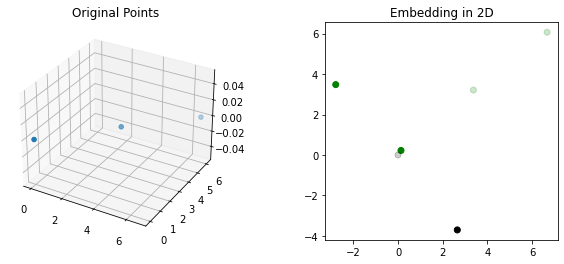

In [81]:
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(coordinates[0,:], coordinates[1,:], coordinates[2,:])
plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(Sstar[0,:], Sstar[1,:], color=c_set, alpha=1.0)
plt.scatter(S    [0,:], S    [1,:], color=c_set, alpha=0.2)
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

Introduction of the controlled displacement

In [82]:
deltaX = deltaY = 0.1

deltaSprime = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
deltaSprime[:,0] = [deltaX,deltaY]
print(deltaSprime)

[[0.1 0.  0. ]
 [0.1 0.  0. ]]


In [83]:
Sprime = S + deltaSprime
print(Sprime)

[[0.1        3.37713248 6.67753783]
 [0.1        3.20876826 6.06695918]]


Phi prime definition

In [91]:
Phiprime = np.array([np.diag(Sprime.T@Sprime)]).T
print(Phiprime)

DMprime = Phiprime@e.T - 2*Sprime.T@Sprime + e@Phiprime.T

[[2.00000000e-02]
 [2.17012176e+01]
 [8.13975052e+01]]


Let's have a look at the distance matrices. They are pretty similar, since the displacement is very small. GOOD

In [92]:
print(DMprime)
print(DM2)

[[ 0.         20.40403741 78.86860579]
 [20.40403741  0.         19.06193081]
 [78.86860579 19.06193081  0.        ]]
[[ 0.         21.70121755 81.3975052 ]
 [21.70121755  0.         19.06193081]
 [81.3975052  19.06193081  0.        ]]


DMprime breakdown analysis (as on the paper)

In [93]:
piece1 = DM2 - DMprime
print(piece1)

[[0.00000000e+00 1.29718015e+00 2.52889940e+00]
 [1.29718015e+00 0.00000000e+00 3.55271368e-15]
 [2.52889940e+00 3.55271368e-15 0.00000000e+00]]


In [94]:
piece2 = np.zeros((n_robots,n_robots))
piece2[1:,0] = (deltaX**2 + deltaY**2)*np.ones(n_robots-1)
piece2[0,1:] = (deltaX**2 + deltaY**2)*np.ones(n_robots-1)
print(piece2)

[[0.   0.02 0.02]
 [0.02 0.   0.  ]
 [0.02 0.   0.  ]]


In [95]:
piece3 = -2*((S.T@deltaSprime).T + S.T@deltaSprime)
print(piece3)

[[-0.         -1.31718015 -2.5488994 ]
 [-1.31718015 -0.         -0.        ]
 [-2.5488994  -0.         -0.        ]]


In [96]:
#FINAL RESULT [SHOULD BE VERY CLOSED TO ZERO --> GOOD]
print(piece1+piece2+piece3)

[[ 0.00000000e+00 -5.32907052e-15  2.66453526e-15]
 [-1.77635684e-15  0.00000000e+00  3.55271368e-15]
 [ 2.66453526e-15  3.55271368e-15  0.00000000e+00]]


In [98]:
a2 = DM2[0,1] - DMprime[0,1] + deltaX**2 + deltaY**2
b2 = -2*(Sstar[0,1]*deltaX + Sstar[1,1]*deltaY)    
c2 =  2*(Sstar[0,1]*deltaY - Sstar[1,1]*deltaX)    

a3 = DM2[0,2] - DMprime[0,2] + deltaX**2 + deltaY**2
b3 = -2*(Sstar[0,2]*deltaX + Sstar[1,2]*deltaY)     
c3 =  2*(Sstar[0,2]*deltaY - Sstar[1,2]*deltaX)    

sinTheta = (a3*b2-a2*b3)/(b3*c2-b2*c3)
cosTheta = (a2*c3-a3*c2)/(b3*c2-b2*c3)
print(sinTheta,cosTheta)
theta = np.arctan2(sinTheta,cosTheta)
print('Theta: %f' % (theta))

mod = np.sqrt(sinTheta**2+cosTheta**2)
sinTheta /= mod
cosTheta /= mod

theta = np.arctan2(sinTheta,cosTheta)

print('Theta: %f' % (theta))
print(sinTheta**2+cosTheta**2)


0.006301289413969504 18.420135501645547
Theta: 0.000342
Theta: 0.000342
1.0


In [99]:
#rotMatrix = np.array([[cosTheta,sinTheta],[-sinTheta,cosTheta]])
print(rotateMatrix(theta))

[[ 9.99999941e-01  3.42087008e-04]
 [-3.42087008e-04  9.99999941e-01]]


In [101]:
#Flip matrix
F = np.array([[-1,0],[0,1]])
print(F)

[[-1  0]
 [ 0  1]]


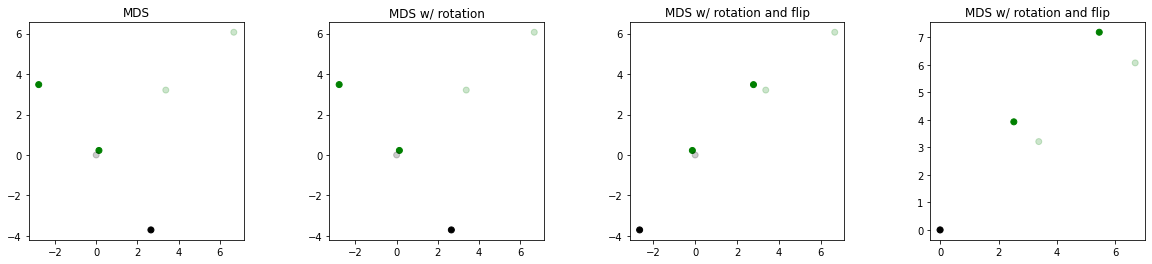

[[ 2.65461435  0.13361068 -2.78822504]
 [-3.70403099  0.22392742  3.48010357]]
[[0.         3.37713248 6.67753783]
 [0.         3.20876826 6.06695918]]


In [105]:
S2 = rotateMatrix(theta)@Sstar
S3 = rotateMatrix(theta)@F@Sstar

fig = plt.figure(3, (20,4))
ax = fig.add_subplot(141)
plt.scatter(Sstar[0,:], Sstar[1,:], color=c_set, alpha=1.0)
plt.scatter(S    [0,:], S    [1,:], color=c_set, alpha=0.2)
plt.title('MDS')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(142)
plt.scatter(S2[0,:], S2[1,:], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(143)
plt.scatter(S3[0,:], S3[1,:], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation and flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(144)
plt.scatter(S3[0,:]-[S3[0,0] for _ in range(n_robots)], S3[1,:]-[S3[1,0] for _ in range(n_robots)], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation and flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

print(S2)
print(S)

In [78]:
for i in range(n_robots-1):
    print((Sstar[0,i]-Sstar[0,i+1])**2 + (Sstar[1,i]-Sstar[1,i+1])**2 - 
    (S2[0,i]-S2[0,i+1])**2 - (S2[1,i]-S2[1,i+1])**2)

print(Sstar)
print(S2)

-7.105427357601002e-15
-1.7763568394002505e-15
[[ 4.04108376 -0.30682815 -3.73425562]
 [ 2.09043799  0.33230479 -2.42274278]]
[[ 2.13893189  0.32858721 -2.4675191 ]
 [-4.01562689  0.3108061   3.70482079]]
